# Federated Learning for RNN and RNN LSTM

## Import Libraries, Import and Split Data

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from keras.optimizers import Adam
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

num_rounds = 2
# Load the dataset from the Excel file
data = pd.read_excel('../KDD_DDoS.xlsx')

# Extract input features and output labels
inputs = data.iloc[:, :41].values
labels = data.iloc[:, 41:42].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2)

## Define a function to create and return Model based on entered parameters

In [3]:
def create_model(model_type, num_input, num_layers, num_nodes, num_output):
    model = keras.Sequential()

    # Add input layer
    if model_type == 'RNN':
        model.add(keras.layers.SimpleRNN(num_nodes, input_shape=(1,num_input), return_sequences=True))
    elif model_type == 'LSTM':
        model.add(keras.layers.LSTM(num_nodes, input_shape=(1, num_input), return_sequences=True))

    # Add hidden layers
    for _ in range(num_layers):
        model.add(keras.layers.Dense(num_nodes, activation='relu'))

    # Add output layer
    model.add(keras.layers.Dense(num_output, activation='sigmoid'))

    return model

# Perform federated learning
num_clients = 20# Number of clients/participants

## Split Training data into small batches 

## Define Functions:

### fed_learning( ) and round_iter( )

In [4]:
# Split the training data into smaller client datasets
client_data = np.array_split(X_train, num_clients)  # client_data[0] ... client_data[9]
client_labels = np.array_split(y_train, num_clients)

def fed_learning(client_data, client_labels, server_model):
    local_model = tf.keras.models.clone_model(server_model)
    local_model.set_weights(server_model.get_weights())
    local_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # change the dimension here!!!
    client_data2 = np.array(client_data)
    client_data2 = client_data2.reshape(client_data2.shape[0], 1, client_data2.shape[1])
    
    client_labels = np.array(client_labels)
    client_labels = client_labels.reshape(client_labels.shape[0], 1)  # Reshape client_labels
    
    # Perform local training on the client's data
    local_model.fit(client_data2, client_labels, epochs=10, batch_size=32, verbose=0)
    return local_model

# Round iteration
def round_iter(num_rounds):
    
    #list to hold value for each round 
    accuracy_list = []
    tpr_list = []
    fpr_list = []
    
    for round_ in range(num_rounds):       
        # Iterate over each client and perform local training
        for client in range(num_clients):
            local_model = fed_learning(client_data[client], client_labels[client], model) 
            # Update the global model with the client's weights
            global_weights = model.get_weights()
            local_weights = local_model.get_weights()
            averaged_weights = [(global_weights[i] + local_weights[i]) / 2 for i in range(len(global_weights))]
            model.set_weights(averaged_weights)

            X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
            loss, accuracy = model.evaluate(X_test2, y_test)
            print("\n*********** Round-", round_, ":Client", client, " ***********\n")
            print(f'Test loss: {loss:.4f}')
            print(f'Test accuracy: {accuracy:.4f}')
            
            # Calculate TPR and FPR
            y_pred = model.predict(X_test2)
            y_pred_binary = (y_pred > 0.5).astype(int)
            tp = np.sum((y_test == 1) & (y_pred_binary == 1))
            fp = np.sum((y_test == 0) & (y_pred_binary == 1))
            tn = np.sum((y_test == 0) & (y_pred_binary == 0))
            fn = np.sum((y_test == 1) & (y_pred_binary == 0))
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)

            # Append values to lists
            accuracy_list.append(accuracy)
            tpr_list.append(tpr)
            fpr_list.append(fpr)

    # Evaluate the global model on the testing data
    print("\n=========== Round-", round_, ":Client", client, " ===========\n")
    X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    loss, accuracy = model.evaluate(X_test2, y_test)
    print(f'Test loss: {loss:.4f}')
    print(f'Test accuracy: {accuracy:.4f}')
    
    return accuracy_list, tpr_list, fpr_list

## Run defined functions to evaluate RNN

### Get metrics to plot Graph 

In [5]:
#RNN
# Create Model
model = create_model('RNN', 41, 4, 64, 1)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#round iteration & fed learning get metrics

rnn_acc, rnn_tpr, rnn_fpr = round_iter(num_rounds)

print(f'rnn accuracy list {rnn_acc}')
print(f'rnn accuracy list {rnn_tpr}')
print(f'rnn accuracy list {rnn_fpr}')

2023-05-17 01:38:43.348821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


183/183 [==============================] - 1s 1ms/step - loss: 0.2174 - accuracy: 0.9448

*********** Round- 0 :Client 0  ***********

Test loss: 0.2174
Test accuracy: 0.9448
183/183 [==============================] - 0s 1ms/step - loss: 0.1458 - accuracy: 0.9476

*********** Round- 0 :Client 1  ***********

Test loss: 0.1458
Test accuracy: 0.9476
183/183 [==============================] - 0s 1ms/step - loss: 0.1189 - accuracy: 0.9542

*********** Round- 0 :Client 2  ***********

Test loss: 0.1189
Test accuracy: 0.9542
183/183 [==============================] - 0s 1ms/step - loss: 0.1175 - accuracy: 0.9549

*********** Round- 0 :Client 3  ***********

Test loss: 0.1175
Test accuracy: 0.9549
183/183 [==============================] - 0s 1ms/step - loss: 0.1332 - accuracy: 0.9254

*********** Round- 0 :Client 4  ***********

Test loss: 0.1332
Test accuracy: 0.9254
183/183 [==============================] - 0s 1ms/step - loss: 0.1058 - accuracy: 0.9553

*********** Round- 0 :Client 5  ***

183/183 [==============================] - 0s 1ms/step - loss: 0.0473 - accuracy: 0.9868

*********** Round- 1 :Client 15  ***********

Test loss: 0.0473
Test accuracy: 0.9868
183/183 [==============================] - 0s 1ms/step - loss: 0.0724 - accuracy: 0.9714

*********** Round- 1 :Client 16  ***********

Test loss: 0.0724
Test accuracy: 0.9714
183/183 [==============================] - 0s 1ms/step - loss: 0.0706 - accuracy: 0.9765

*********** Round- 1 :Client 17  ***********

Test loss: 0.0706
Test accuracy: 0.9765
183/183 [==============================] - 0s 1ms/step - loss: 0.0589 - accuracy: 0.9782

*********** Round- 1 :Client 18  ***********

Test loss: 0.0589
Test accuracy: 0.9782
183/183 [==============================] - 0s 1ms/step - loss: 0.0658 - accuracy: 0.9707

*********** Round- 1 :Client 19  ***********

Test loss: 0.0658
Test accuracy: 0.9707
183/183 [==============================] - 0s 819us/step

=========== Round- 1 :Client 19  ===========

183/183 [=======

## Run defined functions to evaluate RNN LSTM

### Get Metrics to plot graph

In [6]:
#LSTM
# Create Model
model = create_model('LSTM', 41, 4, 64, 1)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#round iteration & fed learning
lstm_acc, lstm_tpr, lstm_fpr = round_iter(num_rounds)

print(f'lstm accuracy list {lstm_acc}')
print(f'lstm accuracy list {lstm_tpr}')
print(f'lstm accuracy list {lstm_fpr}')

183/183 [==============================] - 1s 1ms/step - loss: 0.3052 - accuracy: 0.9069

*********** Round- 0 :Client 0  ***********

Test loss: 0.3052
Test accuracy: 0.9069
183/183 [==============================] - 0s 1ms/step - loss: 0.1567 - accuracy: 0.9383

*********** Round- 0 :Client 1  ***********

Test loss: 0.1567
Test accuracy: 0.9383
183/183 [==============================] - 0s 1ms/step - loss: 0.1127 - accuracy: 0.9524

*********** Round- 0 :Client 2  ***********

Test loss: 0.1127
Test accuracy: 0.9524
183/183 [==============================] - 0s 1ms/step - loss: 0.0986 - accuracy: 0.9582

*********** Round- 0 :Client 3  ***********

Test loss: 0.0986
Test accuracy: 0.9582
183/183 [==============================] - 0s 1ms/step - loss: 0.0904 - accuracy: 0.9709

*********** Round- 0 :Client 4  ***********

Test loss: 0.0904
Test accuracy: 0.9709
183/183 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.9666

*********** Round- 0 :Client 5  ***

183/183 [==============================] - 0s 1ms/step - loss: 0.0505 - accuracy: 0.9901

*********** Round- 1 :Client 16  ***********

Test loss: 0.0505
Test accuracy: 0.9901
183/183 [==============================] - 0s 1ms/step - loss: 0.0745 - accuracy: 0.9698

*********** Round- 1 :Client 17  ***********

Test loss: 0.0745
Test accuracy: 0.9698
183/183 [==============================] - 0s 1ms/step - loss: 0.0535 - accuracy: 0.9899

*********** Round- 1 :Client 18  ***********

Test loss: 0.0535
Test accuracy: 0.9899
183/183 [==============================] - 0s 1ms/step - loss: 0.0583 - accuracy: 0.9793

*********** Round- 1 :Client 19  ***********

Test loss: 0.0583
Test accuracy: 0.9793
183/183 [==============================] - 0s 969us/step

=========== Round- 1 :Client 19  ===========

183/183 [==============================] - 0s 1ms/step - loss: 0.0583 - accuracy: 0.9793
Test loss: 0.0583
Test accuracy: 0.9793
lstm accuracy list [0.9069408774375916, 0.9383033514022827, 0.9

In [7]:
# test lenght 
lenof_rnn_acc = len(rnn_acc)
lenof_lstm_acc = len(lstm_acc)

print(f'rnn {lenof_rnn_acc}')
print(f'lstm {lenof_lstm_acc }')

rnn 40
lstm 40


# Plot graphs

In [8]:
#import library
import matplotlib.pyplot as plt

## Accuracy vs rounds

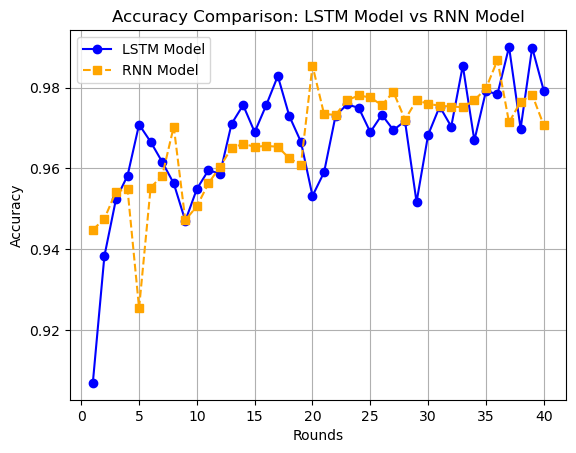

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the lengths of lstm_acc and rnn_acc are the same
num_rounds = len(lstm_acc)

# Aligning the lengths of lstm_acc and rnn_acc to the specified number of rounds
lstm_acc = lstm_acc[:num_rounds]
rnn_acc = rnn_acc[:num_rounds]

# Set the x-axis values
x = np.arange(1, num_rounds + 1)

# Plot the line for LSTM Model accuracy
plt.plot(x, lstm_acc, marker='o', linestyle='-', color='blue', label='LSTM Model')

# Plot the line for RNN Model accuracy
plt.plot(x, rnn_acc, marker='s', linestyle='--', color='orange', label='RNN Model')

# Set the x-axis label
plt.xlabel('Rounds')

# Set the y-axis label
plt.ylabel('Accuracy')

# Set the title of the graph
plt.title('Accuracy Comparison: LSTM Model vs RNN Model')

# Add a legend
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

## TPR vs Rounds

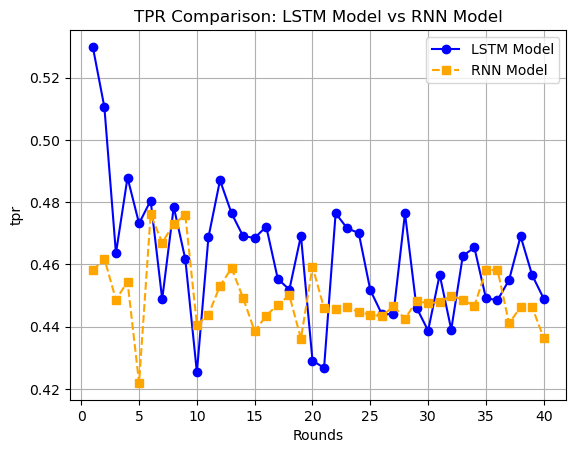

In [10]:
# Aligning the lengths of lstm_tpr and rnn_tpr to the specified number of rounds
lstm_tpr = lstm_tpr[:num_rounds]
rnn_tpr = rnn_tpr[:num_rounds]

# Set the x-axis values
x = np.arange(1, num_rounds + 1)

# Plot the line for LSTM Model tpr
plt.plot(x, lstm_tpr, marker='o', linestyle='-', color='blue', label='LSTM Model')

# Plot the line for RNN Model tpr
plt.plot(x, rnn_tpr, marker='s', linestyle='--', color='orange', label='RNN Model')

# Set the x-axis label
plt.xlabel('Rounds')

# Set the y-axis label
plt.ylabel('tpr')

# Set the title of the graph
plt.title('TPR Comparison: LSTM Model vs RNN Model')

# Add a legend
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

## FPR vs Rounds

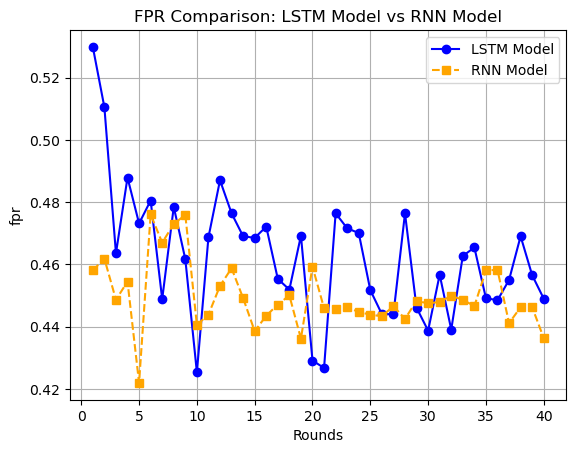

In [11]:
# Aligning the lengths of lstm_fpr and rnn_fpr to the specified number of rounds
lstm_fpr = lstm_fpr[:num_rounds]
rnn_fpr = rnn_fpr[:num_rounds]

# Set the x-axis values
x = np.arange(1, num_rounds + 1)

# Plot the line for LSTM Model fpr
plt.plot(x, lstm_fpr, marker='o', linestyle='-', color='blue', label='LSTM Model')

# Plot the line for RNN Model fpr
plt.plot(x, rnn_fpr, marker='s', linestyle='--', color='orange', label='RNN Model')

# Set the x-axis label
plt.xlabel('Rounds')

# Set the y-axis label
plt.ylabel('fpr')

# Set the title of the graph
plt.title('FPR Comparison: LSTM Model vs RNN Model')

# Add a legend
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

## Print Data Frame for report

In [12]:
# Assuming the lengths of fpr, tpr, and accuracy are the same
data = {
    'Rounds': range(1, len(rnn_fpr) + 1),
    'RNN Accuracy': rnn_acc,
    'RNN FPR': rnn_fpr,
    'RNN TPR': rnn_tpr,
    'LSTM Accuracy': lstm_acc,
    'LSTM FPR': lstm_fpr,
    'LSTM TPR': lstm_tpr
    
}
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)  # Show all column
# Set the maximum number of rows to display
pd.set_option('display.max_rows', 10)  # Show all rows# Show all rows
df = pd.DataFrame(data)
print(df)

    Rounds  RNN Accuracy   RNN FPR   RNN TPR  LSTM Accuracy  LSTM FPR  \
0        1      0.944816  0.458098  0.458098       0.906941  0.529906   
1        2      0.947558  0.461868  0.461868       0.938303  0.510540   
2        3      0.954242  0.448672  0.448672       0.952356  0.463582   
3        4      0.954927  0.454499  0.454499       0.958183  0.487918   
4        5      0.925450  0.421937  0.421937       0.970865  0.473179   
..     ...           ...       ...       ...            ...       ...   
35      36      0.986804  0.458269  0.458269       0.978406  0.448500   
36      37      0.971380  0.441131  0.441131       0.990060  0.455013   
37      38      0.976521  0.446272  0.446272       0.969837  0.469066   
38      39      0.978235  0.446272  0.446272       0.989889  0.456555   
39      40      0.970694  0.436332  0.436332       0.979263  0.449015   

    LSTM TPR  
0   0.529906  
1   0.510540  
2   0.463582  
3   0.487918  
4   0.473179  
..       ...  
35  0.448500  
36 